In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease   
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1254 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4587 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3040 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4741 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3350 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [55.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1561 kB]
Get:13 ht

In [2]:
!pip install openpyxl

  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/c1/8b/5fe2cc11fee489817272089c4203e679c63b570a5aaeb18d852ae3cbba6a/et_xmlfile-2.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.2 MB/s eta 0:00:00 0:00:01


In [3]:
import pandas as pd

# Read the Excel file
file_path = "/home/jovyan/onmixed-data-last/emotion_metadata_removed_specific.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Display the first 10 elements (rows)
print(data.head(10))

     expected_filename dominant_emotion  Adjusted Valence  Adjusted Arousal
0  happiness_00024.mp4        happiness            0.8010            0.1530
1       fear_00031.mp4             fear           -0.1032            0.6794
2  happiness_00035.mp4        happiness            0.7387            0.1411
3  happiness_00040.mp4        happiness            0.8010            0.1530
4  happiness_00049.mp4        happiness            0.6497            0.1241
5  happiness_00050.mp4        happiness            0.7921            0.1513
6  happiness_00056.mp4        happiness            0.7298            0.1394
7    disgust_00064.mp4          disgust           -0.5032            0.2960
8       fear_00070.mp4             fear           -0.0936            0.6162
9  happiness_00077.mp4        happiness            0.7387            0.1411


In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from decord import VideoReader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Enable GPU acceleration if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

# Configuration
input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync  # Increased batch size
initial_learning_rate = 1e-4
min_learning_rate = 1e-6
epochs = 50

# Paths
video_base = "/home/jovyan/onmixed-data-last/MAFW_FSLF"
metadata_path = "/home/jovyan/onmixed-data-last/emotion_metadata_removed_specific.xlsx"
model_path = "/home/jovyan/onmixed-data-last/model"

# 1. Load and preprocess metadata
metadata = pd.read_excel(metadata_path, engine='openpyxl')
metadata['video_path'] = metadata['expected_filename'].apply(
    lambda fn: os.path.join(video_base, fn)
)

# 2. Video validation and filtering
def is_video_valid(fpath):
    try:
        vr = VideoReader(fpath)
        return len(vr) > num_frame  # Ensure video has enough frames
    except Exception as e:
        print(f"Error reading {fpath}: {str(e)}")
        return False

valid_mask = metadata['video_path'].apply(
    lambda p: os.path.exists(p) and is_video_valid(p))
df = metadata[valid_mask].copy()

# Normalize targets between -1 and 1 (already done in your data)
print(f"Loaded {len(df)} valid samples")
print("Target ranges:")
print(f"Valence: {df['Adjusted Valence'].min():.2f} to {df['Adjusted Valence'].max():.2f}")
print(f"Arousal: {df['Adjusted Arousal'].min():.2f} to {df['Adjusted Arousal'].max():.2f}")

# 3. Enhanced video reading with augmentation
def read_video(path):
    path = path.numpy().decode('utf-8')
    vr = VideoReader(path)
    total = len(vr)
    
    # Random temporal sampling for training
    if tf.random.uniform(()) > 0.5:  # 50% chance to augment
        start = tf.random.uniform((), 0, max(1, total - num_frame), dtype=tf.int32)
        idx = tf.range(start, start + num_frame)
    else:
        idx = np.linspace(0, total - 1, num_frame, dtype=np.int32)
    
    idx = np.clip(idx, 0, total - 1)
    frames = vr.get_batch(idx).asnumpy()
    
    # Convert and resize
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, [input_size, input_size])
    
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        frames = tf.image.flip_left_right(frames)
    
    # Random brightness adjustment
    frames = tf.image.random_brightness(frames, max_delta=0.1)
    
    return frames

def load_video(path, targets):
    vid = tf.py_function(read_video, inp=[path], Tout=tf.float32)
    vid.set_shape([num_frame, input_size, input_size, 3])
    targets = tf.cast(targets, tf.float32)
    return vid, targets


# 4. Data pipeline with caching
def create_ds(df, target_cols, shuffle=True, augment=False):
    paths = df['video_path'].values
    targets = df[target_cols].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((paths, targets))
    
    if shuffle:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    
    if augment:
        ds = ds.map(
            lambda p, t: load_video(p, t),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        # For validation/test, use deterministic frame sampling
        ds = ds.map(
            lambda p, t: (tf.py_function(
                lambda x: read_video(x, deterministic=True),
                inp=[p], Tout=tf.float32
            ), t),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# 5. Stratified split by emotion (if available) or random split
if 'dominant_emotion' in df.columns:
    train_df, temp_df = train_test_split(
        df, test_size=0.3, stratify=df['dominant_emotion'], random_state=42
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['dominant_emotion'], random_state=42
    )
else:
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

target_cols = ['Adjusted Valence', 'Adjusted Arousal']

train_ds = create_ds(train_df, target_cols, shuffle=True, augment=True)
val_ds = create_ds(val_df, target_cols, shuffle=False)
test_ds = create_ds(test_df, target_cols, shuffle=False)

# 6. Load pretrained model with error handling
try:
    pretrained = tf.saved_model.load(model_path)
    print("Successfully loaded pretrained model")
except Exception as e:
    print(f"Error loading pretrained model: {str(e)}")
    raise

# 7. Enhanced model architecture
with strategy.scope():
    inp = layers.Input((num_frame, input_size, input_size, 3))
    
    # Feature extraction
    x = TFSMLayer(pretrained)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Regression head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Separate outputs with different activations if needed
    valence_out = layers.Dense(1, activation='tanh', name='valence')(x)
    arousal_out = layers.Dense(1, activation='tanh', name='arousal')(x)
    
    model = keras.Model(inp, [valence_out, arousal_out], name="va_regressor")
    
    # Custom learning rate schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=len(train_ds)*10,
        decay_rate=0.9,
        staircase=True
    )
    
    # Separate losses and metrics for each output
    model.compile(
        optimizer=keras.optimizers.Adam(lr_schedule),
        loss={
            'valence': 'mse',
            'arousal': 'mse'
        },
        metrics={
            'valence': ['mae', keras.metrics.RootMeanSquaredError()],
            'arousal': ['mae', keras.metrics.RootMeanSquaredError()]
        },
        loss_weights=[1.0, 1.0]
    )

model.summary()

# 8. Training with callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=min_learning_rate
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks
)

# 9. Evaluation and visualization
test_results = model.evaluate(test_ds, verbose=2)
print("\nTest Results:")
print(f"Valence MAE: {test_results[3]:.4f}, RMSE: {test_results[5]:.4f}")
print(f"Arousal MAE: {test_results[4]:.4f}, RMSE: {test_results[6]:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
metrics = ['loss', 'valence_mae', 'arousal_mae']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(metric)
    plt.legend()
plt.tight_layout()
plt.show()

# Sample predictions
sample_videos = test_df.sample(3)['video_path'].values
for vid_path in sample_videos:
    frames = read_video(tf.constant(vid_path))
    frames = tf.expand_dims(frames, 0)
    v_pred, a_pred = model.predict(frames)
    print(f"\nVideo: {os.path.basename(vid_path)}")
    print(f"Predicted Valence: {v_pred[0][0]:.4f}, Arousal: {a_pred[0][0]:.4f}")

2025-06-28 15:20:32.153856: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 2g.10gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-06-28 15:20:35.335398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7898 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/fear_01471.mp4: [15:20:36] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/happiness_01629.mp4: [15:20:36] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/sadness_01788.mp4: [15:20:37] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/sadness_02839.mp4: [15:20:37] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/sadness_03045.mp4:

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5570f3910040] moov atom not found
[15:20:38] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/anger_03810.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5570f38eb200] moov atom not found
[15:20:38] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5570f3910040] moov atom not found
[15:20:38] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4, Invalid data found when processing input


Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4: Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4...
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10135.mp4: [15:20:38] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4: Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4...
Error reading /home/jovyan/onmixed-data-last/MAFW_FSLF/fear_10575.mp4: [15:20:38] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1
Loaded 0 valid samples
Target ranges:
Valence: nan to nan
Arousal: nan to nan


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [6]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from decord import VideoReader

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Enable GPU acceleration if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

# Basic config
input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  # adjust per your system

# Paths
video_base = "/home/jovyan/onmixed-data-last/MAFW_FSLF"
metadata_path = "/home/jovyan/onmixed-data-last/emotion_metadata_removed_specific.xlsx"
model_path = "/home/jovyan/onmixed-data-last/model"

# 1. Load metadata and attach video paths
metadata = pd.read_excel(metadata_path, engine='openpyxl')
metadata['video_path'] = metadata['expected_filename'].apply(
    lambda fn: os.path.join(video_base, fn)
)

# Helper: validate video files
def is_video_valid(fpath):
    try:
        vr = VideoReader(fpath)
        return len(vr) > 0
    except:
        return False

# 2. Filter only valid samples
valid_rows = []
for _, row in metadata.iterrows():
    p = row['video_path']
    if os.path.exists(p) and is_video_valid(p):
        valid_rows.append(row)
    else:
        print(f"Skipping invalid: {p}")
df = pd.DataFrame(valid_rows).sample(frac=1).reset_index(drop=True)

# 3. Video reading and formatting
def read_video(path):
    path = path.numpy().decode()
    vr = VideoReader(path)
    total = len(vr)
    idx = np.linspace(0, total - 1, num_frame, dtype=np.int32)
    idx = np.clip(idx, 0, total - 1)
    frames = vr.get_batch(idx).asnumpy()
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, [input_size, input_size])
    return frames

def load_video(path, target):
    vid = tf.py_function(read_video, inp=[path], Tout=tf.float32)
    vid.set_shape([num_frame, input_size, input_size, 3])
    target = tf.cast(target, tf.float32)
    return vid, target

# 4. Data loader
def create_ds(df, target_cols, shuffle=True):
    paths = df['video_path'].values
    targets = df[target_cols].values.astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((paths, targets))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 5. Split dataset (70/15/15)
n = len(df)
n_train = int(0.7 * n)
n_val = int(0.15 * n)
train_df = df[:n_train]
val_df = df[n_train:n_train + n_val]
test_df = df[n_train + n_val:]

# 🔧 Select targets: Valence and Arousal (both)
target_cols = ['Adjusted Valence', 'Adjusted Arousal']

train_ds = create_ds(train_df, target_cols, shuffle=True)
val_ds = create_ds(val_df, target_cols, shuffle=False)
test_ds = create_ds(test_df, target_cols, shuffle=False)

# 6. Load pretrained model
pretrained = tf.saved_model.load(model_path)

class TFSMLayer(layers.Layer):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, x):
        return self.model.signatures['serving_default'](input_1=x)['output_1']

# 7. Build model
with strategy.scope():
    inp = layers.Input((num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained)(inp)  # returns shape (None, 400)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(2, activation='tanh', dtype='float32')(x)
    model = keras.Model(inp, out, name="valence_arousal_regressor")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='mse',
        metrics=[keras.metrics.MeanAbsoluteError()]
    )

model.summary()

# 8. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1
)

# 9. Evaluate
test_loss, test_mae = model.evaluate(test_ds, verbose=2)
print(f"Test MSE: {test_loss:.4f} — Test MAE: {test_mae:.4f}")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/fear_01471.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/happiness_01629.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/sadness_01788.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/sadness_02839.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/sadness_03045.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/fear_03567.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/anger_03810.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55713fd2aa40] moov atom not found
[15:26:06] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/anger_03810.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5570f3ca5800] moov atom not found
[15:26:06] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5570f3c88e00] moov atom not found
[15:26:06] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4, Invalid data found when processing input


Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10135.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4
Skipping invalid: /home/jovyan/onmixed-data-last/MAFW_FSLF/fear_10575.mp4
Model: "valence_arousal_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer_1 (TFSMLayer)    (None, 400)               0         
                                                                 
 dense (Dense)               (None, 128)               51328     
                                                                 
 dropout (Dropout)           (None, 128)               0         


2025-06-28 15:26:20.210576: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 930
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:13"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
        dim {
          size: 2
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
      

Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2025-06-28 15:26:29.632731: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557138b45a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-28 15:26:29.632772: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 2g.10gb, Compute Capability 8.0
2025-06-28 15:26:30.038586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-06-28 15:26:31.531800: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


InvalidArgumentError: Graph execution error:

Detected at node 'valence_arousal_regressor/tfsm_layer_1/StatefulPartitionedCall' defined at (most recent call last):
    File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_416/2386525753.py", line 113, in call
      return self.model.signatures['serving_default'](input_1=x)['output_1']
Node: 'valence_arousal_regressor/tfsm_layer_1/StatefulPartitionedCall'
Expects arg[0] to be float but half is provided
	 [[{{node valence_arousal_regressor/tfsm_layer_1/StatefulPartitionedCall}}]] [Op:__inference_train_function_158534]

In [9]:
import os
import warnings
import cv2
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure GPU if available
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

input_size = 224
num_frame = 16
batch_size = 2 * strategy.num_replicas_in_sync

# Paths
video_base_path = "/home/jovyan/onmixed-data-last/MAFW_FSLF"
metadata_path = "/home/jovyan/onmixed-data-last/emotion_metadata_removed_specific.xlsx"

# Load metadata
import pandas as pd
metadata = pd.read_excel(metadata_path)

# Filter out invalid videos
def is_video_valid(file_path):
    try:
        vr = VideoReader(file_path)
        return len(vr) > 0
    except:
        return False

    
import pandas as pd
def create_dataframe(metadata_df, video_path):
    data = []
    for idx, row in metadata_df.iterrows():
        filename = row['expected_filename']
        video_file_path = os.path.join(video_path, filename)
        if os.path.exists(video_file_path) and is_video_valid(video_file_path):
            data.append({
                'video_path': os.path.abspath(video_file_path),
                'valence': float(row['Adjusted Valence']),
                'arousal': float(row['Adjusted Arousal'])
            })
        else:
            print(f"Skipping invalid or missing video: {filename}")
    return pd.DataFrame(data).sample(frac=1).reset_index(drop=True)

df = create_dataframe(metadata, video_base_path)

# Split data (80% train, 10% val, 10% test)
total = len(df)
train_df = df[:int(0.8 * total)]
val_df = df[int(0.8 * total):int(0.9 * total)]
test_df = df[int(0.9 * total):]

# Video loader
def read_video(file_path):
    file_path = file_path.numpy().decode('utf-8')
    vr = VideoReader(file_path)
    total_frames = len(vr)
    frame_indices = np.linspace(0, total_frames - 1, num_frame, dtype=np.int32)
    frame_indices = np.clip(frame_indices, 0, total_frames - 1)
    frames = vr.get_batch(frame_indices).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, valence, arousal):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])
    label = tf.stack([valence, arousal])
    return video, label

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    paths = df['video_path'].values
    valences = df['valence'].values.astype(np.float32)
    arousals = df['arousal'].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((paths, valences, arousals))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataloader(train_df, batch_size, shuffle=True)
val_ds = create_dataloader(val_df, batch_size, shuffle=False)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

# Load pretrained model
model_path = "/home/jovyan/onmixed-data-last/model"
pretrained_model = tf.saved_model.load(model_path)

class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Build regression model
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    outputs = layers.Dense(2, dtype='float32')(x)  # 2 outputs: valence & arousal
    model = keras.Model(inputs=inputs, outputs=outputs, name="valence_arousal_regressor")

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=0.05),
        loss='mse',
        metrics=[keras.metrics.MeanAbsoluteError(name='mae')]
    )

model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(val_df) // batch_size,
    epochs=30,
    verbose=1
)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Skipping invalid or missing video: fear_01471.mp4
Skipping invalid or missing video: happiness_01629.mp4
Skipping invalid or missing video: sadness_01788.mp4
Skipping invalid or missing video: sadness_02839.mp4
Skipping invalid or missing video: sadness_03045.mp4
Skipping invalid or missing video: fear_03567.mp4
Skipping invalid or missing video: anger_03810.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55713288d200] moov atom not found
[15:39:08] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/anger_03810.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55716709df40] moov atom not found
[15:39:09] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55714adc69c0] moov atom not found
[15:39:09] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4, Invalid data found when processing input


Skipping invalid or missing video: disgust_08776.mp4
Skipping invalid or missing video: disgust_10135.mp4
Skipping invalid or missing video: disgust_10160.mp4
Skipping invalid or missing video: fear_10575.mp4
Model: "valence_arousal_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer_2 (TFSMLayer)    (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 802       
                                                                 
Total params: 802 (3.13 KB)
Trainable params: 802 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-06-28 15:39:24.385211: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1063
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:38"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-06-28 15:39:35.432479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


531/531 [==============================] - ETA: 0s - loss: 0.4270 - mae: 0.5131

2025-06-28 15:41:46.375343: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 133
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:43"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

531/531 [==============================] - 164s 280ms/step - loss: 0.4270 - mae: 0.5131 - val_loss: 0.2722 - val_mae: 0.4171
Epoch 2/30
531/531 [==============================] - 144s 270ms/step - loss: 0.2474 - mae: 0.3987 - val_loss: 0.2218 - val_mae: 0.3759
Epoch 3/30
531/531 [==============================] - 144s 269ms/step - loss: 0.2074 - mae: 0.3637 - val_loss: 0.2092 - val_mae: 0.3598
Epoch 4/30
531/531 [==============================] - 143s 269ms/step - loss: 0.1972 - mae: 0.3553 - val_loss: 0.2309 - val_mae: 0.3809
Epoch 5/30
531/531 [==============================] - 143s 269ms/step - loss: 0.1895 - mae: 0.3454 - val_loss: 0.2036 - val_mae: 0.3594
Epoch 6/30
531/531 [==============================] - 143s 269ms/step - loss: 0.1827 - mae: 0.3409 - val_loss: 0.2143 - val_mae: 0.3640
Epoch 7/30
531/531 [==============================] - 143s 268ms/step - loss: 0.1795 - mae: 0.3403 - val_loss: 0.1959 - val_mae: 0.3583
Epoch 8/30
531/531 [==============================] - 143s 

In [10]:
import os
import warnings
import cv2
import numpy as np
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure GPU if available
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd_ in device_name:
        tf.config.experimental.set_memory_growth(pd_, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()

input_size = 224
num_frame = 16
batch_size = 8 * strategy.num_replicas_in_sync

# Paths
video_base_path = "/home/jovyan/onmixed-data-last/MAFW_FSLF"
metadata_path = "/home/jovyan/onmixed-data-last/emotion_metadata_removed_specific.xlsx"

# Load metadata
metadata = pd.read_excel(metadata_path)

# Check video validity
def is_video_valid(file_path):
    try:
        vr = VideoReader(file_path)
        return len(vr) > 0
    except:
        return False

def create_dataframe(metadata_df, video_path):
    data = []
    for idx, row in metadata_df.iterrows():
        filename = row['expected_filename']
        video_file_path = os.path.join(video_path, filename)
        if os.path.exists(video_file_path) and is_video_valid(video_file_path):
            data.append({
                'video_path': os.path.abspath(video_file_path),
                'valence': float(row['Adjusted Valence']),
                'arousal': float(row['Adjusted Arousal'])
            })
        else:
            print(f"Skipping invalid or missing video: {filename}")
    return pd.DataFrame(data).sample(frac=1).reset_index(drop=True)

df = create_dataframe(metadata, video_base_path)

# Split data
total = len(df)
train_df = df[:int(0.8 * total)]
val_df = df[int(0.8 * total):int(0.9 * total)]
test_df = df[int(0.9 * total):]

# Video loader functions
def read_video(file_path):
    file_path = file_path.numpy().decode('utf-8')
    vr = VideoReader(file_path)
    total_frames = len(vr)
    frame_indices = np.linspace(0, total_frames - 1, num_frame, dtype=np.int32)
    frame_indices = np.clip(frame_indices, 0, total_frames - 1)
    frames = vr.get_batch(frame_indices).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, valence, arousal):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])
    label = tf.stack([valence, arousal])
    return video, label

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    paths = df['video_path'].values
    valences = df['valence'].values.astype(np.float32)
    arousals = df['arousal'].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((paths, valences, arousals))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataloader(train_df, batch_size, shuffle=True)
val_ds = create_dataloader(val_df, batch_size, shuffle=False)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

# Load pretrained model
model_path = "/home/jovyan/onmixed-data-last/model"
pretrained_model = tf.saved_model.load(model_path)

class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# CCC metric function
def concordance_cc(y_true, y_pred):
    true_mean = tf.reduce_mean(y_true, axis=0)
    pred_mean = tf.reduce_mean(y_pred, axis=0)
    cov = tf.reduce_mean((y_true - true_mean) * (y_pred - pred_mean), axis=0)
    true_var = tf.reduce_mean(tf.square(y_true - true_mean), axis=0)
    pred_var = tf.reduce_mean(tf.square(y_pred - pred_mean), axis=0)
    ccc = (2 * cov) / (true_var + pred_var + tf.square(true_mean - pred_mean) + 1e-8)
    return tf.reduce_mean(ccc)

# CCC loss (optional)
def ccc_loss(y_true, y_pred):
    return 1 - concordance_cc(y_true, y_pred)

# Build regression model and compile
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    outputs = layers.Dense(2, dtype='float32')(x)  # valence & arousal
    model = keras.Model(inputs=inputs, outputs=outputs, name="valence_arousal_regressor")

    # Choose your loss here: MSE or CCC loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.MeanSquaredError(),  # or use ccc_loss if you want
        metrics=[
            keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.MeanMetricWrapper(concordance_cc, name='ccc')
        ]
    )

model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(val_df) // batch_size,
    epochs=50,
    verbose=1
)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Skipping invalid or missing video: fear_01471.mp4
Skipping invalid or missing video: happiness_01629.mp4
Skipping invalid or missing video: sadness_01788.mp4
Skipping invalid or missing video: sadness_02839.mp4
Skipping invalid or missing video: sadness_03045.mp4
Skipping invalid or missing video: fear_03567.mp4
Skipping invalid or missing video: anger_03810.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55716b039500] moov atom not found
[17:07:15] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/anger_03810.mp4, Invalid data found when processing input
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55716bb64e80] moov atom not found
[17:07:15] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_08776.mp4, Invalid data found when processing input


Skipping invalid or missing video: disgust_08776.mp4
Skipping invalid or missing video: disgust_10135.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5571658ac480] moov atom not found
[17:07:15] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF/disgust_10160.mp4, Invalid data found when processing input


Skipping invalid or missing video: disgust_10160.mp4
Skipping invalid or missing video: fear_10575.mp4
Model: "valence_arousal_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer_3 (TFSMLayer)    (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 802       
                                                                 
Total params: 802 (3.13 KB)
Trainable params: 802 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-06-28 17:07:31.277561: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1063
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:510"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 0.4446 - mae: 0.5215 - ccc: 0.0863

2025-06-28 17:09:59.495612: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 133
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:515"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

132/132 [==============================] - 172s 1s/step - loss: 0.4446 - mae: 0.5215 - ccc: 0.0863 - val_loss: 0.3426 - val_mae: 0.4790 - val_ccc: 0.1157
Epoch 2/50
132/132 [==============================] - 150s 1s/step - loss: 0.2816 - mae: 0.4223 - ccc: 0.1274 - val_loss: 0.2797 - val_mae: 0.4174 - val_ccc: 0.1377
Epoch 3/50
132/132 [==============================] - 152s 1s/step - loss: 0.2358 - mae: 0.3865 - ccc: 0.1760 - val_loss: 0.2619 - val_mae: 0.4137 - val_ccc: 0.1639
Epoch 4/50
132/132 [==============================] - 151s 1s/step - loss: 0.2119 - mae: 0.3671 - ccc: 0.2268 - val_loss: 0.2645 - val_mae: 0.4176 - val_ccc: 0.1794
Epoch 5/50
132/132 [==============================] - 152s 1s/step - loss: 0.1919 - mae: 0.3494 - ccc: 0.2506 - val_loss: 0.2368 - val_mae: 0.3837 - val_ccc: 0.1833
Epoch 6/50
132/132 [==============================] - 148s 1s/step - loss: 0.1868 - mae: 0.3438 - ccc: 0.2579 - val_loss: 0.2433 - val_mae: 0.3964 - val_ccc: 0.1992
Epoch 7/50
132/132 [=

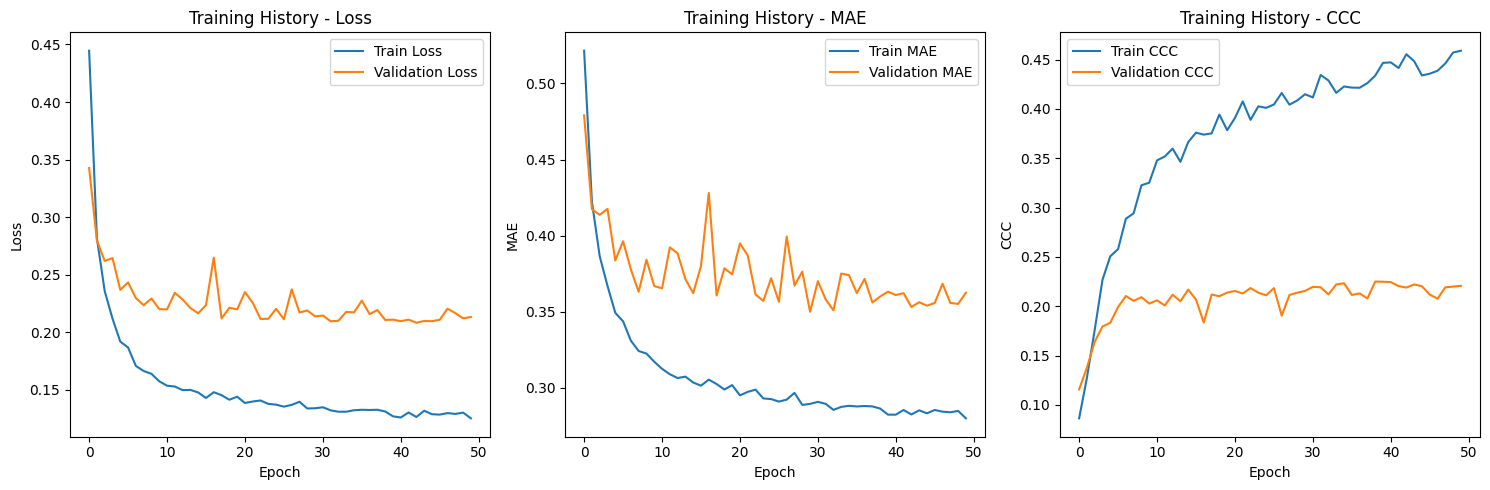


Evaluating on test set...


2025-06-28 19:12:06.361723: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 133
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:519"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

Test Loss: 0.2314
Test MAE: 0.3780
Test CCC: 0.2508

Generating predictions...


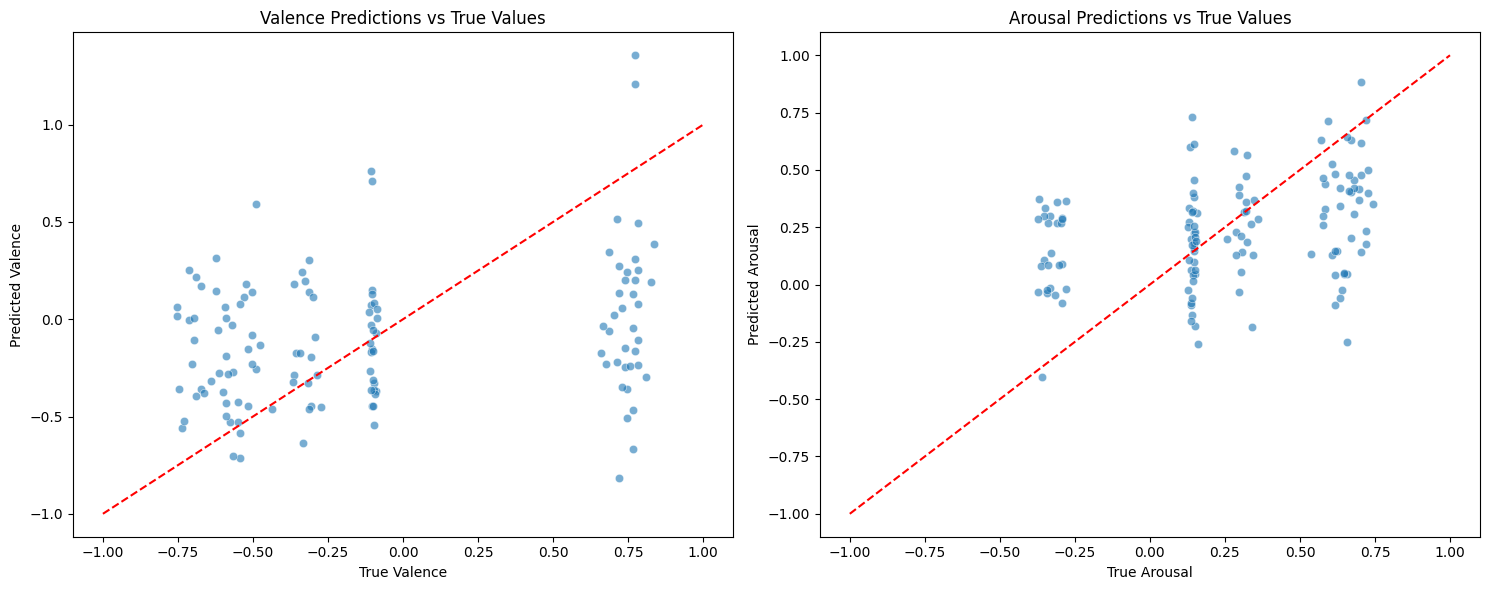

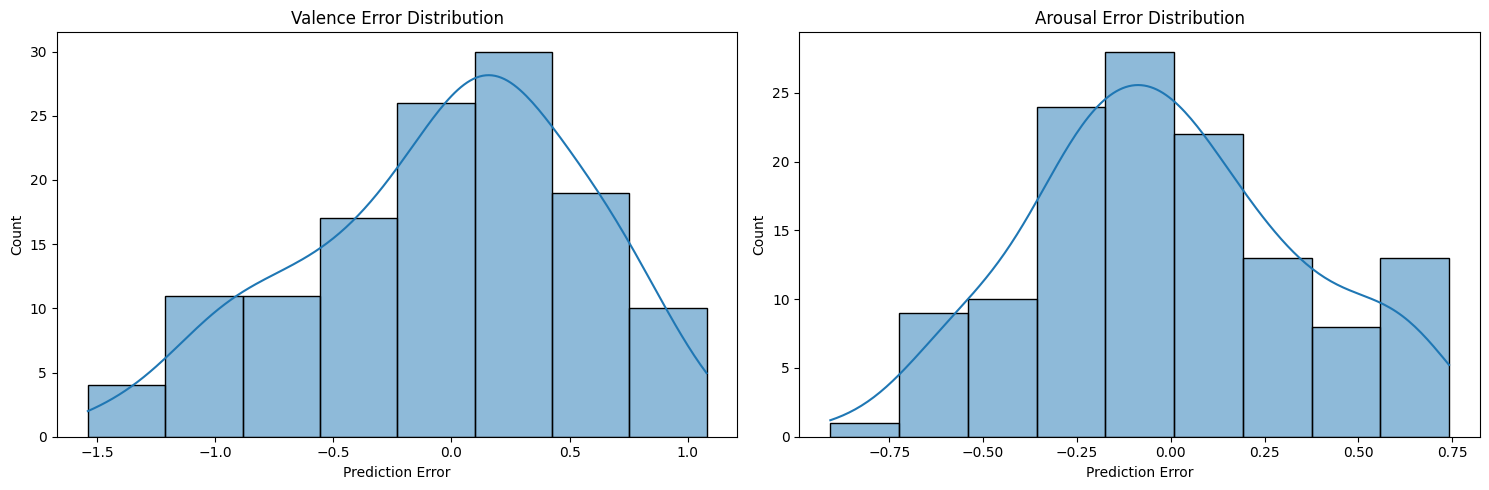


Detailed Performance Metrics:

Valence:
MSE: 0.3364
MAE: 0.4691
CCC: 0.2229

Arousal:
MSE: 0.1265
MAE: 0.2868
CCC: 0.3004

Visualizing sample predictions...


In [ ]:
# Results Visualization and Presentation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. Plot training history
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training History - MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# CCC
plt.subplot(1, 3, 3)
plt.plot(history.history['ccc'], label='Train CCC')
plt.plot(history.history['val_ccc'], label='Validation CCC')
plt.title('Training History - CCC')
plt.ylabel('CCC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Evaluate on test set
print("\nEvaluating on test set...")
test_results = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")
print(f"Test CCC: {test_results[2]:.4f}")

# 3. Get predictions for visualization
print("\nGenerating predictions...")
all_true = []
all_pred = []

for batch in test_ds:
    videos, labels = batch
    preds = model.predict(videos, verbose=0)
    all_true.extend(labels.numpy())
    all_pred.extend(preds)

all_true = np.array(all_true)
all_pred = np.array(all_pred)

# 4. Scatter plots of predictions vs true values
plt.figure(figsize=(15, 6))

# Valence
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_true[:, 0], y=all_pred[:, 0], alpha=0.6)
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
plt.title('Valence Predictions vs True Values')
plt.xlabel('True Valence')
plt.ylabel('Predicted Valence')

# Arousal
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_true[:, 1], y=all_pred[:, 1], alpha=0.6)
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
plt.title('Arousal Predictions vs True Values')
plt.xlabel('True Arousal')
plt.ylabel('Predicted Arousal')

plt.tight_layout()
plt.show()

# 5. Error distribution
errors = all_pred - all_true
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(errors[:, 0], kde=True)
plt.title('Valence Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(1, 2, 2)
sns.histplot(errors[:, 1], kde=True)
plt.title('Arousal Error Distribution')
plt.xlabel('Prediction Error')

plt.tight_layout()
plt.show()

# 6. Calculate and display metrics per dimension
print("\nDetailed Performance Metrics:")
metrics = {
    'Valence': {
        'MSE': mean_squared_error(all_true[:, 0], all_pred[:, 0]),
        'MAE': mean_absolute_error(all_true[:, 0], all_pred[:, 0]),
        'CCC': concordance_cc(all_true[:, 0], all_pred[:, 0]).numpy()
    },
    'Arousal': {
        'MSE': mean_squared_error(all_true[:, 1], all_pred[:, 1]),
        'MAE': mean_absolute_error(all_true[:, 1], all_pred[:, 1]),
        'CCC': concordance_cc(all_true[:, 1], all_pred[:, 1]).numpy()
    }
}

for dim, vals in metrics.items():
    print(f"\n{dim}:")
    for metric, value in vals.items():
        print(f"{metric}: {value:.4f}")

# 7. Sample video frame visualization with predictions
print("\nVisualizing sample predictions...")
sample_batch = next(iter(test_ds))
sample_videos, sample_labels = sample_batch
sample_preds = model.predict(sample_videos, verbose=0)

plt.figure(figsize=(15, 10))
for i in range(min(4, batch_size)):  # Show first 4 samples
    plt.subplot(2, 2, i+1)
    # Display middle frame
    middle_frame = sample_videos[i, num_frame//2].numpy()
    plt.imshow(middle_frame)
    plt.title(f"True V: {sample_labels[i][0]:.2f}, A: {sample_labels[i][1]:.2f}\n"
              f"Pred V: {sample_preds[i][0]:.2f}, A: {sample_preds[i][1]:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Analyzing video: /home/jovyan/onmixed-data-last/WhatsApp Video 2025-06-20 at 13.00.03 (1).mp4


2025-06-28 19:39:29.063232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


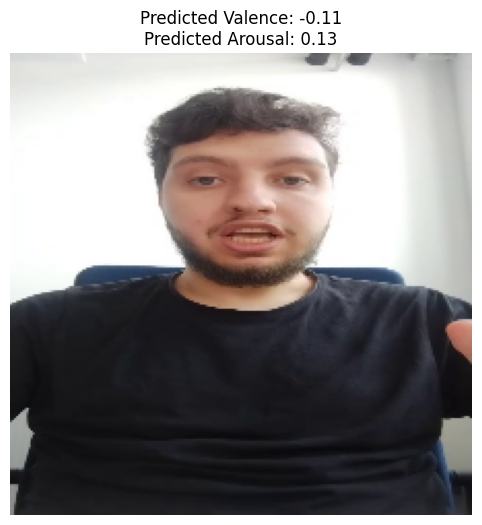


Prediction Results:
Valence: -0.1057 (range: -1 to 1, where -1=negative, 1=positive)
Arousal: 0.1326 (range: -1 to 1, where -1=calm, 1=excited)

Interpretation Guide:
Valence:
- Positive (>0): Generally positive emotion (happy, content)
- Negative (<0): Generally negative emotion (sad, angry)
- Near 0: Neutral emotion

Arousal:
- Positive (>0): High energy/excitement
- Negative (<0): Low energy/calmness
- Near 0: Moderate energy level


In [12]:
# Cell 3: Test on a specific video file
test_video_path = "/home/jovyan/onmixed-data-last/WhatsApp Video 2025-06-20 at 13.00.03 (1).mp4"

# Create a function to process a single video
def predict_video_emotion(video_path, model):
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None
    
    # Check if video is valid
    if not is_video_valid(video_path):
        print(f"Error: Video file is invalid or corrupted")
        return None
    
    # Create a dummy label (won't be used)
    dummy_valence = 0.0
    dummy_arousal = 0.0
    
    # Create a single-element dataset
    ds = tf.data.Dataset.from_tensor_slices(([video_path], [dummy_valence], [dummy_arousal]))
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(1)
    
    # Get the video tensor
    for video, _ in ds:
        # Make prediction
        prediction = model.predict(video, verbose=0)
        valence = prediction[0][0]
        arousal = prediction[0][1]
        
        # Display the middle frame with prediction
        middle_frame = video[0, num_frame//2].numpy()
        plt.figure(figsize=(8, 6))
        plt.imshow(middle_frame)
        plt.title(f"Predicted Valence: {valence:.2f}\nPredicted Arousal: {arousal:.2f}")
        plt.axis('off')
        plt.show()
        
        return valence, arousal

# Make prediction
print(f"Analyzing video: {test_video_path}")
valence, arousal = predict_video_emotion(test_video_path, model)

if valence is not None and arousal is not None:
    print("\nPrediction Results:")
    print(f"Valence: {valence:.4f} (range: -1 to 1, where -1=negative, 1=positive)")
    print(f"Arousal: {arousal:.4f} (range: -1 to 1, where -1=calm, 1=excited)")
    
    # Interpretation guide
    print("\nInterpretation Guide:")
    print("Valence:")
    print("- Positive (>0): Generally positive emotion (happy, content)")
    print("- Negative (<0): Generally negative emotion (sad, angry)")
    print("- Near 0: Neutral emotion")
    
    print("\nArousal:")
    print("- Positive (>0): High energy/excitement")
    print("- Negative (<0): Low energy/calmness")
    print("- Near 0: Moderate energy level")

Analyzing video: /home/jovyan/onmixed-data-last/anger_angry_01-01-05-01-02-01-03.mp4


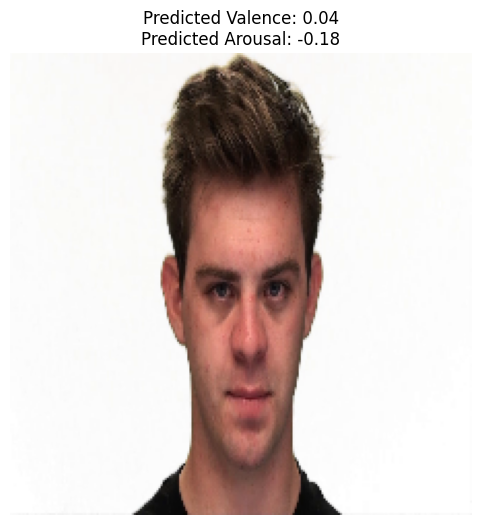

In [17]:
# Cell 3: Test on a specific video file
test_video_path = "/home/jovyan/onmixed-data-last/anger_angry_01-01-05-01-02-01-03.mp4"

# Create a function to process a single video
def predict_video_emotion(video_path, model):
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None
    
    # Check if video is valid
    if not is_video_valid(video_path):
        print(f"Error: Video file is invalid or corrupted")
        return None
    
    # Create a dummy label (won't be used)
    dummy_valence = 0.0
    dummy_arousal = 0.0
    
    # Create a single-element dataset
    ds = tf.data.Dataset.from_tensor_slices(([video_path], [dummy_valence], [dummy_arousal]))
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(1)
    
    # Get the video tensor
    for video, _ in ds:
        # Make prediction
        prediction = model.predict(video, verbose=0)
        valence = prediction[0][0]
        arousal = prediction[0][1]
        
        # Display the middle frame with prediction
        middle_frame = video[0, num_frame//2].numpy()
        plt.figure(figsize=(8, 6))
        plt.imshow(middle_frame)
        plt.title(f"Predicted Valence: {valence:.2f}\nPredicted Arousal: {arousal:.2f}")
        plt.axis('off')
        plt.show()
        
        return valence, arousal

# Make prediction
print(f"Analyzing video: {test_video_path}")
valence, arousal = predict_video_emotion(test_video_path, model)



Analyzing video: /home/jovyan/onmixed-data-last/joy_155_4.mp4


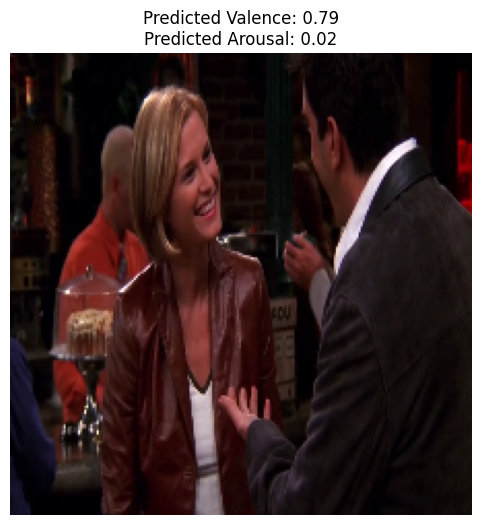

In [16]:
# Cell 3: Test on a specific video file
test_video_path = "/home/jovyan/onmixed-data-last/joy_155_4.mp4"

# Create a function to process a single video
def predict_video_emotion(video_path, model):
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None
    
    # Check if video is valid
    if not is_video_valid(video_path):
        print(f"Error: Video file is invalid or corrupted")
        return None
    
    # Create a dummy label (won't be used)
    dummy_valence = 0.0
    dummy_arousal = 0.0
    
    # Create a single-element dataset
    ds = tf.data.Dataset.from_tensor_slices(([video_path], [dummy_valence], [dummy_arousal]))
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(1)
    
    # Get the video tensor
    for video, _ in ds:
        # Make prediction
        prediction = model.predict(video, verbose=0)
        valence = prediction[0][0]
        arousal = prediction[0][1]
        
        # Display the middle frame with prediction
        middle_frame = video[0, num_frame//2].numpy()
        plt.figure(figsize=(8, 6))
        plt.imshow(middle_frame)
        plt.title(f"Predicted Valence: {valence:.2f}\nPredicted Arousal: {arousal:.2f}")
        plt.axis('off')
        plt.show()
        
        return valence, arousal

# Make prediction
print(f"Analyzing video: {test_video_path}")
valence, arousal = predict_video_emotion(test_video_path, model)



Analyzing video: /home/jovyan/onmixed-data-last/sadness_398_3.mp4


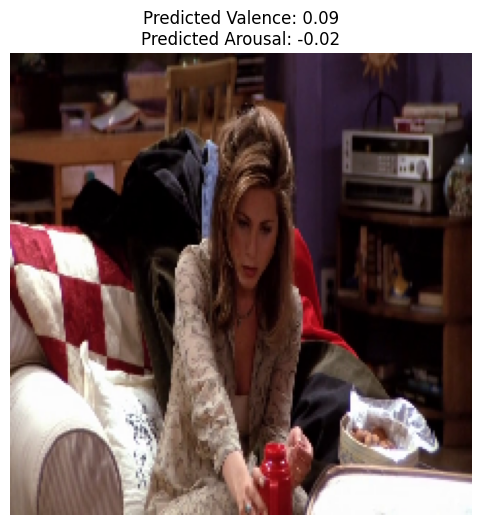

In [19]:
# Cell 3: Test on a specific video file
test_video_path = "/home/jovyan/onmixed-data-last/sadness_398_3.mp4"

# Create a function to process a single video
def predict_video_emotion(video_path, model):
    # Check if video exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None
    
    # Check if video is valid
    if not is_video_valid(video_path):
        print(f"Error: Video file is invalid or corrupted")
        return None
    
    # Create a dummy label (won't be used)
    dummy_valence = 0.0
    dummy_arousal = 0.0
    
    # Create a single-element dataset
    ds = tf.data.Dataset.from_tensor_slices(([video_path], [dummy_valence], [dummy_arousal]))
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(1)
    
    # Get the video tensor
    for video, _ in ds:
        # Make prediction
        prediction = model.predict(video, verbose=0)
        valence = prediction[0][0]
        arousal = prediction[0][1]
        
        # Display the middle frame with prediction
        middle_frame = video[0, num_frame//2].numpy()
        plt.figure(figsize=(8, 6))
        plt.imshow(middle_frame)
        plt.title(f"Predicted Valence: {valence:.2f}\nPredicted Arousal: {arousal:.2f}")
        plt.axis('off')
        plt.show()
        
        return valence, arousal

# Make prediction
print(f"Analyzing video: {test_video_path}")
valence, arousal = predict_video_emotion(test_video_path, model)

